In [1]:
# Import required libraries

# OCR DocTR libraries
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# To save OCR as dataframe
import pandas as pd
import json
import re
import numpy as np
import math
from collections import defaultdict, Counter



C:\Users\indra\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm






In [2]:
# Create the model OCR

model = ocr_predictor(pretrained=True)

In [3]:
# Open image

# Image
# single_img_doc = DocumentFile.from_images(r"C:\OCR\Mandiri 4 8.jpg")

# Multiple page images

# BM Transaction Inquiry
input_OCR = DocumentFile.from_images([r"C:\OCR\Mandiri 4 8.jpg", r"C:\OCR\Mandiri 4 9.jpg"])

# BM Account Statement
# input_OCR = DocumentFile.from_images([r"C:\OCR\Mandiri 1.jpg", r"C:\OCR\Mandiri 2 1.jpg"])

# BM Laporan Account Statement
# input_OCR = DocumentFile.from_images([r"C:\OCR\Rekening Koran 1_Page_01.jpg", r"C:\OCR\Rekening Koran 1_Page_05.jpg"])

# UOB PDF
# input_OCR = DocumentFile.from_pdf(r"C:\OCR\Contoh RK UOB.pdf")

# BCA Rekening Tahapan
# input_OCR = DocumentFile.from_images([r"C:\OCR\BCA_RekeningTahapan01.jpeg"])

# BNI Syariah


# BRI

# To test various type of Bank within 1 pdf 
# input_OCR = DocumentFile.from_images([r"C:\OCR\Mandiri 2 1.jpg", r"C:\OCR\Mandiri 4 8.jpg", r"C:\OCR\Rekening Koran 1_Page_05.jpg",r"C:\OCR\BCA_RekeningTahapan01.jpeg", r"C:\OCR\BNISyariah_RekeningKoran01.png", r"C:\OCR\BRI_RekeningKoran01.jpg"])


# Webpage (requires `weasyprint` to be installed)
# webpage_doc = DocumentFile.from_url("https://www.yoursite.com")


In [4]:
# Run OCR and save the OCR result

result = model(input_OCR)

In [5]:
# Save the result of the OCR as JSON file
json_output = result.export()

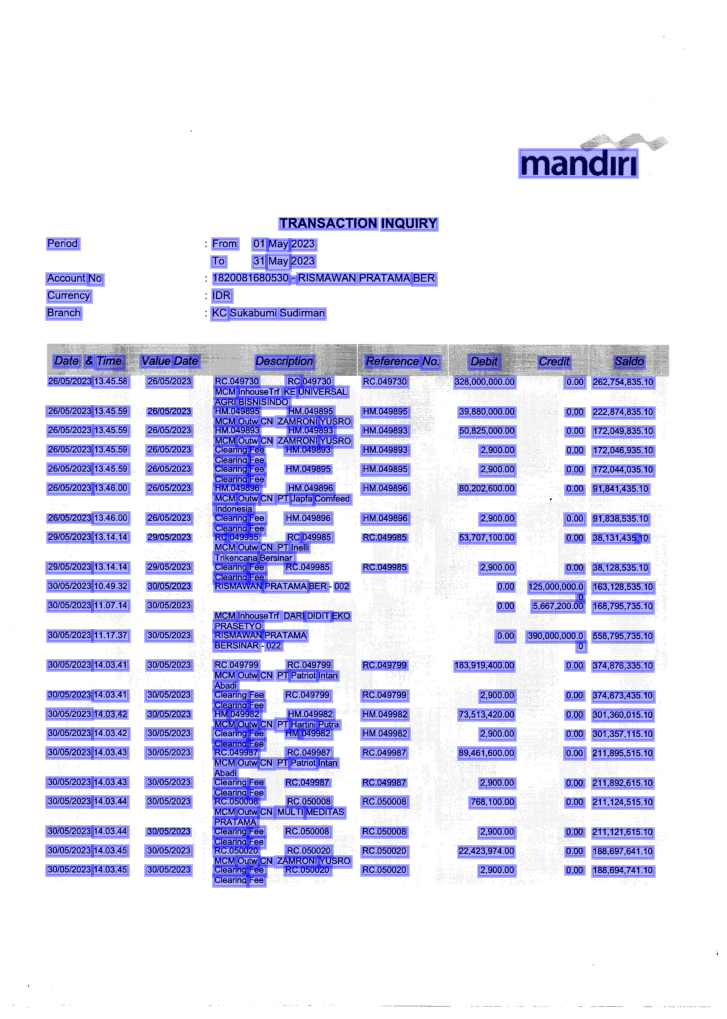

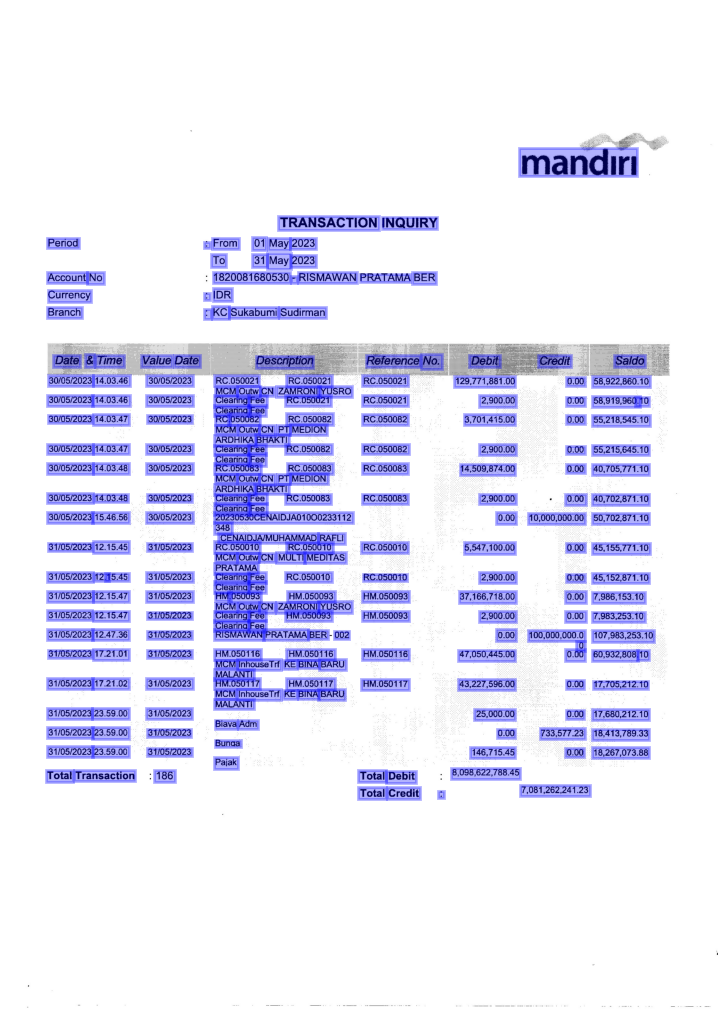

In [6]:
# Optional Code
# Show the result of OCR in image form, along with the OCR boxes

result.show(interactive=True, preserve_aspect_ratio= False)

In [7]:
# Function to read a JSON file from OCR and return it as dataframe

import json
import pandas as pd

def json_to_dataframe(data):
    """
    Converts a JSON structure into a pandas DataFrame.
    
    Parameters:
    data (dict): JSON data as a dictionary.
    
    Returns:
    pd.DataFrame: DataFrame containing the parsed data.
    """
    rows = []
    for page in data["pages"]:
        page_idx = page["page_idx"]
        language = page.get("language", "Unknown")  # Set default if missing
        for block in page["blocks"]:
            block_geometry = json.dumps(block["geometry"])  # Convert dict to string
            for line in block["lines"]:
                line_geometry = json.dumps(line["geometry"])  # Convert dict to string
                for word in line["words"]:
                    word_value = word["value"]
                    word_confidence = word["confidence"]
                    word_geometry = json.dumps(word["geometry"])  # Convert dict to string
                    rows.append([
                        page_idx,
                        language,
                        block_geometry,
                        line_geometry,
                        word_value,
                        word_confidence,
                        word_geometry
                    ])
    
    df = pd.DataFrame(rows, columns=[
        "page_idx",
        "language",
        "block_geometry",
        "line_geometry",
        "word_value",
        "word_confidence",
        "word_geometry"
    ])
    
    return df

# Convert JSON to DataFrame
df_json = json_to_dataframe(json_output)

# Display the first 5 rows of the DataFrame
df_json

# Print for debugging purpose only
df_json.to_excel(r"C:\OCR\temporaryexcel.xlsx", index=False)

In [8]:
# Loading Master Parameter

""""
Metadata of Master Data Parameter
OCR_Found_Type_01:  First Word that must be found to categorize the bank and type
OCR_Found_Type_02:  Secpnd Word that must be found to categorize the bank and type
OCR_Found_Type_03:  Third Word that must be found to categorize the bank and type
Bank:   Name of the Bank
Type:   Type of the bank statement
DC_SingleColumn:    Whether the Debit Credit is a single column or not. TRUE is a single column
DC_Location:  If DC_SingleColumn is TRUE then how to difference Debit and Credit by the location: F is front (left) and B is back (right)
DC_Identifier:  If DC_SingleColumn is TRUE then how to difference Debit and Credit by the type: C is Credit, D is Debit

Column names: Date_Trx, Date_Val, Description, Reference, Debit, Credit, Balance
Within each column name:
The name of the column name for each Bank and Type
The default coordinate value for all column of each Bank and Type (in case the OCR failed to capture the coordinate of the column)
The coordinate threshold for left and right of each column (to categorize the type of each column)

YColumn_Coord_Default: where the column names located. This is also the start of the table
Summary_Page: If has summary end of total at the end. All is all page. E is Ending only.



"""

# Load Master List of Report Type from CSV with the correct delimiter
fileMD_Parameter_path = r"C:\OCR\MD_BankReportParameters.csv"
masterParameter_df = pd.read_csv(fileMD_Parameter_path, delimiter=';')

## Checking content of PDF by page
If each page of PDF inidcates different bank statement. Then give warning that this PDF contains multiple bank statement
If PDF indicate bank statement. Check if it is the same as what the user indicate when uploading the file. If different, then give warning.

In [9]:
import re
from fuzzywuzzy import fuzz

# Function to normalize text for robust matching
def normalize_text(text):
    # Convert to lower case and remove non-alphanumeric characters
    return re.sub(r'\W+', '', str(text).lower())

# Normalize master data once
def normalize_master_data(master_df):
    master_df['OCR_Found_Bank_normalized'] = master_df['OCR_Found_Bank'].apply(normalize_text)
    for i in range(1, 9):
        master_df[f'OCR_Found_Type_{i:02d}_normalized'] = master_df[f'OCR_Found_Type_{i:02d}'].apply(normalize_text)
    return master_df

# Function to find multiple OCR types using fuzzy matching
def find_multiple_types(ocr_data, master_df, page_index):
    # Filter OCR data for the specified page index
    ocr_data_filtered = ocr_data[ocr_data['page_idx'] == page_index].copy()
    
    # Normalize OCR data for matching
    ocr_data_filtered['word_value_normalized'] = ocr_data_filtered['word_value'].apply(normalize_text)
    
    # Convert OCR data to a set for efficient lookup
    ocr_words_set = set(ocr_data_filtered['word_value_normalized'])
    
    # Check if the bank is matched and at least 5 types match
    best_match = None
    max_matches = 0
    
    for _, row in master_df.iterrows():
        bank_match = any(fuzz.ratio(row['OCR_Found_Bank_normalized'], word) > 80 for word in ocr_words_set)
        if not bank_match:
            continue
        
        matches = 0
        for i in range(1, 9):
            type_match = any(fuzz.ratio(row[f'OCR_Found_Type_{i:02d}_normalized'], word) > 80 for word in ocr_words_set)
            if type_match:
                matches += 1
        
        if matches >= 5 and matches > max_matches:
            max_matches = matches
            best_match = row
    
    if best_match is not None:
        column_name = {
            'DC_Column': best_match['DC_Column'],
            'Date_Trx_Column': best_match['Date_Trx_Column'],
            'Date_Val_Column': best_match['Date_Val_Column'],
            'Description_Column': best_match['Description_Column'],
            'Reference_Column': best_match['Reference_Column'],
            'Debit_Column': best_match['Debit_Column'],
            'Credit_Column': best_match['Credit_Column'],
            'Balance_Column': best_match['Balance_Column']
        }
        setting_parameters = {
            'OD_Possible': best_match['OD_Possible'],
            'OD_Location': best_match['OD_Location'],
            'OD_Identifier': best_match['OD_Identifier'],
            'DC_SingleColumn': best_match['DC_SingleColumn'],
            'DC_Location': best_match['DC_Location'],
            'DC_Identifier': best_match['DC_Identifier'],
            'Summary_Page': best_match['Summary_Page'],
            'Summary_Word': best_match['Summary_Word'],
            'Column_Repeat': best_match['Column_Repeat']
        }
        column_threshold = {
            'DC_Coord_Start': best_match['DC_Coord_Start'],
            'DC_Coord_End': best_match['DC_Coord_End'],
            'Date_Trx_Coord_Start': best_match['Date_Trx_Coord_Start'],
            'Date_Trx_Coord_End': best_match['Date_Trx_Coord_End'],
            'Date_Val_Coord_Start': best_match['Date_Val_Coord_Start'],
            'Date_Val_Coord_End': best_match['Date_Val_Coord_End'],
            'Description_Coord_Start': best_match['Description_Coord_Start'],
            'Description_Coord_End': best_match['Description_Coord_End'],
            'Reference_Coord_Start': best_match['Reference_Coord_Start'],
            'Reference_Coord_End': best_match['Reference_Coord_End'],
            'Debit_Coord_Start': best_match['Debit_Coord_Start'],
            'Debit_Coord_End': best_match['Debit_Coord_End'],
            'Credit_Coord_Start': best_match['Credit_Coord_Start'],
            'Credit_Coord_End': best_match['Credit_Coord_End'],
            'Balance_Coord_Start': best_match['Balance_Coord_Start'],
            'Balance_Coord_End': best_match['Balance_Coord_End']
        }
        column_default = {
            'DC_Coord_Default_Start': best_match['DC_Coord_Default_Start'],
            'DC_Coord_Default_End': best_match['DC_Coord_Default_End'],
            'Date_Trx_Coord_Default_Start': best_match['Date_Trx_Coord_Default_Start'],
            'Date_Trx_Coord_Default_End': best_match['Date_Trx_Coord_Default_End'],
            'Date_Val_Coord_Default_Start': best_match['Date_Val_Coord_Default_Start'],
            'Date_Val_Coord_Default_End': best_match['Date_Val_Coord_Default_End'],
            'Description_Coord_Default_Start': best_match['Description_Coord_Default_Start'],
            'Description_Coord_Default_End': best_match['Description_Coord_Default_End'],
            'Reference_Coord_Default_Start': best_match['Reference_Coord_Default_Start'],
            'Reference_Coord_Default_End': best_match['Reference_Coord_Default_End'],
            'Debit_Coord_Default_Start': best_match['Debit_Coord_Default_Start'],
            'Debit_Coord_Default_End': best_match['Debit_Coord_Default_End'],
            'Credit_Coord_Default_Start': best_match['Credit_Coord_Default_Start'],
            'Credit_Coord_Default_End': best_match['Credit_Coord_Default_End'],
            'Balance_Coord_Default_Start': best_match['Balance_Coord_Default_Start'],
            'Balance_Coord_Default_End': best_match['Balance_Coord_Default_End'],
            'YColumn_Coord_Default_Start': best_match['YColumn_Coord_Default_Start'],
            'YColumn_Coord_Default_End': best_match['YColumn_Coord_Default_End']
        }
        return best_match['Bank'], best_match['Type'], column_name, setting_parameters, column_threshold, column_default
    
    return None, None, None, None, None, None

# Function to check and return the bank and type based on OCR data for all pages
def check_and_return_all_pages(df_json, masterParameter_df):
    # Ensure master data is normalized
    masterParameter_df = normalize_master_data(masterParameter_df)
    
    results = []
    
    # Iterate through all unique page indices
    unique_page_indices = df_json['page_idx'].unique()
    for page_index in unique_page_indices:
        bank_name, report_type, column_name, setting_parameters, column_threshold, column_default = find_multiple_types(df_json, masterParameter_df, page_index)
        
        if bank_name is not None:
            results.append({
                "page_index": page_index,                
                "bank_name": bank_name,
                "report_type": report_type,
                "column_name": column_name,
                "setting_parameters": setting_parameters,
                "column_threshold": column_threshold,
                "column_default": column_default
            })
    
    return results

# Assuming df_json is your OCR data DataFrame and masterParameter_df is already loaded
parameters = check_and_return_all_pages(df_json, masterParameter_df)

# Print results for debugging purpose
for param in parameters:
    print(param['page_index'], param['bank_name'], param['report_type'], param['column_name']['Date_Trx_Column'])


0 Bank Mandiri Transaction Inquiry Time
1 Bank Mandiri Transaction Inquiry Time


## Coding to identify nama kolom dari tabel -> Time & date, value date
Also identify where the column name located from y-axis perspective

In [10]:
import pandas as pd
import re
import math
from collections import Counter, defaultdict
import numpy as np
from fuzzywuzzy import fuzz

# Function to normalize text for robust matching
def normalize_text(text):
    return re.sub(r'\W+', '', str(text).lower())

# Function to perform fuzzy matching with a threshold
def fuzzy_match(text, target_text, threshold=80):
    return fuzz.partial_ratio(normalize_text(text), normalize_text(target_text)) >= threshold

def extract_coordinates_full(geometry):
    if pd.isna(geometry) or not isinstance(geometry, str):
        return None
    try:
        clean_str = geometry.translate({ord(i): None for i in '()[] '})
        coords = clean_str.split(',')
        if len(coords) != 4:
            raise ValueError("Coordinate string does not have exactly four values")
        coord_floats = [float(coord) for coord in coords]
        return ((coord_floats[0], coord_floats[1]), (coord_floats[2], coord_floats[3]))
    except Exception as e:
        print(f"Error extracting coordinates: {str(e)}")
        return None

def calculate_mode(values):
    if not values:
        return None
    value_counter = Counter(values)
    mode = value_counter.most_common(1)
    return mode[0][0] if mode else None

def calculate_and_print_statistics(filtered_df, parameters):
    all_global_y_end_q3 = {}
    all_global_keyword_coords = {}
    all_x_start_counter = Counter()
    all_x_end_counter = Counter()
    all_column_modes = {}
    all_column_common_y_start = []
    all_column_common_y_end = []

    # Step 1: Calculate global common y_start and y_end
    all_y_starts = []
    all_y_ends = []

    for param in parameters:
        keywords = {value: key for key, value in param['column_name'].items()}

        for _, group in filtered_df.groupby('page_idx'):
            coords_list = group['coordinates'].tolist()
            if coords_list:
                y_start = [round(coord[0][1], 2) for coord in coords_list if coord]
                y_end = [round(coord[1][1], 2) for coord in coords_list if coord]
                all_y_starts.extend(y_start)
                all_y_ends.extend(y_end)

    column_common_y_start = calculate_mode(all_y_starts)
    column_common_y_end = calculate_mode(all_y_ends)

    # Step 2: Find words within the common y_start and y_end range
    threshold = 0.02
    for param in parameters:
        keywords = {value: key for key, value in param['column_name'].items()}

        global_y_end_q3 = {}
        global_keyword_coords = {key: {'x_start': [], 'x_end': [], 'y_start': [], 'y_end': []} for key in keywords.values()}

        for page, group in filtered_df.groupby('page_idx'):
            coords_list = group['coordinates'].tolist()
            if coords_list:
                x_start = [round(coord[0][0], 2) for coord in coords_list if coord]
                x_end = [round(coord[1][0], 2) for coord in coords_list if coord]
                y_start = [round(coord[0][1], 2) for coord in coords_list if coord]
                y_end = [round(coord[1][1], 2) for coord in coords_list if coord]

                # Only calculate the 75th percentile if y_end is not empty
                if y_end:
                    global_y_end_q3[page] = np.percentile(y_end, 75)
                else:
                    global_y_end_q3[page] = None

                for value, key in keywords.items():
                    if pd.isna(value):
                        global_keyword_coords[key]['x_start'].append(None)
                        global_keyword_coords[key]['x_end'].append(None)
                        global_keyword_coords[key]['y_start'].append(None)
                        global_keyword_coords[key]['y_end'].append(None)
                    else:
                        # Fuzzy match the word in the 'word_value' column
                        keyword_coords = group[group['word_value'].apply(lambda x: fuzzy_match(x, value))]['coordinates']
                        coords_list = keyword_coords.dropna().apply(
                            lambda row: {
                                'x_start': round(float(row[0][0]), 2),
                                'y_start': round(float(row[0][1]), 2),
                                'x_end': round(float(row[1][0]), 2),
                                'y_end': round(float(row[1][1]), 2)
                            }
                        ).tolist()

                        if coords_list:
                            filtered_coords = [
                                coord for coord in coords_list
                                if column_common_y_start - threshold <= coord['y_start'] <= column_common_y_start + threshold
                                and column_common_y_end - threshold <= coord['y_end'] <= column_common_y_end + threshold
                            ]
                            global_keyword_coords[key]['x_start'].extend(coord['x_start'] for coord in filtered_coords)
                            global_keyword_coords[key]['x_end'].extend(coord['x_end'] for coord in filtered_coords)
                            global_keyword_coords[key]['y_start'].extend(coord['y_start'] for coord in filtered_coords)
                            global_keyword_coords[key]['y_end'].extend(coord['y_end'] for coord in filtered_coords)

        column_modes = {}
        for value, key in keywords.items():
            coords = global_keyword_coords[key]
            # Skip None values when calculating the mode
            column_modes[f'{key}_x_start'] = calculate_mode([x for x in coords['x_start'] if x is not None])
            column_modes[f'{key}_x_end'] = calculate_mode([x for x in coords['x_end'] if x is not None])
            column_modes[f'{key}_y_start'] = calculate_mode([y for y in coords['y_start'] if y is not None])
            column_modes[f'{key}_y_end'] = calculate_mode([y for y in coords['y_end'] if y is not None])

        x_start_to_end = defaultdict(list)
        x_end_to_start = defaultdict(list)

        for _, group in filtered_df.groupby('page_idx'):
            for coord in group['coordinates']:
                if coord:
                    x_start, y_start = round(coord[0][0], 2), round(coord[0][1], 2)
                    x_end, y_end = round(coord[1][0], 2), round(coord[1][1], 2)
                    x_start_to_end[x_start].append(x_end)
                    x_end_to_start[x_end].append(x_start)

        x_start_counter = Counter(x_start_to_end)
        x_end_counter = Counter(x_end_to_start)

        all_global_y_end_q3.update(global_y_end_q3)
        for key, value in global_keyword_coords.items():
            if key in all_global_keyword_coords:
                for k, v in value.items():
                    all_global_keyword_coords[key][k].extend(v)
            else:
                all_global_keyword_coords[key] = value
        all_x_start_counter.update(x_start_counter)
        all_x_end_counter.update(x_end_counter)
        all_column_modes.update(column_modes)

    return all_global_y_end_q3, all_global_keyword_coords, all_x_start_counter, all_x_end_counter, all_column_modes, column_common_y_start, column_common_y_end

# Example usage:
df_flexcoord_01 = df_json.copy()
df_flexcoord_01['coordinates'] = df_flexcoord_01['word_geometry'].apply(extract_coordinates_full)

global_y_end_q3, global_keyword_coords, x_start_counter, x_end_counter, column_modes, column_common_y_start, column_common_y_end = calculate_and_print_statistics(df_flexcoord_01, parameters)


# Print common y_start and y_end for each page
for page in global_y_end_q3.keys():
    print(f"Page {page} common y_start: {column_common_y_start}")
    print(f"Page {page} common y_end: {column_common_y_end}")

print(column_modes)


Page 0 common y_start: 0.35
Page 0 common y_end: 0.36
Page 1 common y_start: 0.35
Page 1 common y_end: 0.36
{'DC_Column_x_start': None, 'DC_Column_x_end': None, 'DC_Column_y_start': None, 'DC_Column_y_end': None, 'Date_Trx_Column_x_start': 0.12, 'Date_Trx_Column_x_end': 0.16, 'Date_Trx_Column_y_start': 0.35, 'Date_Trx_Column_y_end': 0.36, 'Date_Val_Column_x_start': 0.18, 'Date_Val_Column_x_end': 0.23, 'Date_Val_Column_y_start': 0.35, 'Date_Val_Column_y_end': 0.36, 'Description_Column_x_start': 0.35, 'Description_Column_x_end': 0.43, 'Description_Column_y_start': 0.35, 'Description_Column_y_end': 0.36, 'Reference_Column_x_start': 0.5, 'Reference_Column_x_end': 0.58, 'Reference_Column_y_start': 0.35, 'Reference_Column_y_end': 0.36, 'Debit_Column_x_start': 0.65, 'Debit_Column_x_end': 0.69, 'Debit_Column_y_start': 0.34, 'Debit_Column_y_end': 0.36, 'Credit_Column_x_start': 0.75, 'Credit_Column_x_end': 0.79, 'Credit_Column_y_start': 0.35, 'Credit_Column_y_end': 0.36, 'Balance_Column_x_start'

In [11]:
# Print results for debugging purpose
for param in parameters:
    print(param['page_index'], param['bank_name'], param['report_type'], param['column_name']['Date_Trx_Column'])



0 Bank Mandiri Transaction Inquiry Time
1 Bank Mandiri Transaction Inquiry Time


In [12]:

def get_parameters_for_page(page_index):
    for param in parameters:
        if param['page_index'] == page_index:
            return param
    return None

def adjust_coordinates(column_modes, page_idx, keyword, column_threshold, column_default):
    """
    Adjust the coordinates based on the column modes for the specific page and keyword.
    If retrieval fails, use the default coordinates with margins.
    """
    try:
        # Get the threshold and default values
        threshold_start_key = f'{keyword}_Coord_Start'
        threshold_end_key = f'{keyword}_Coord_End'
        default_start_key = f'{keyword}_Coord_Default_Start'
        default_end_key = f'{keyword}_Coord_Default_End'

        threshold_start = column_threshold.get(threshold_start_key, np.nan)
        threshold_end = column_threshold.get(threshold_end_key, np.nan)
        default_start = column_default.get(default_start_key, np.nan)
        default_end = column_default.get(default_end_key, np.nan)

        # Retrieve the coordinates from column_modes or use defaults
        x_start_mode = column_modes.get(f'{keyword}_x_start', default_start)
        x_end_mode = column_modes.get(f'{keyword}_x_end', default_end)
        
        x_start = float(x_start_mode) + threshold_start if not np.isnan(threshold_start) else default_start
        x_end = float(x_end_mode) + threshold_end if not np.isnan(threshold_end) else default_end

    except (IndexError, ValueError, TypeError, KeyError):
        x_start = default_start
        x_end = default_end
    return x_start, x_end

def categorize_based_on_coordinates(coords, page_idx, column_modes, parameters):
    if not coords:
        return None

    x_start, y_start = coords[0]
    x_end, y_end = coords[1]

    # Get the parameters for the current page index
    param = get_parameters_for_page(page_idx)
    if not param:
        return "Other"

    column_threshold = param['column_threshold']
    column_default = param['column_default']

    # Retrieve the y_end_q3 for the specific page, defaulting to 0.34 if not present
    # y_threshold = global_y_end_q3.get(page_idx, 0.34)
    y_threshold = column_common_y_end

    # Adjust the coordinates for each keyword
    dc_x_start, dc_x_end = adjust_coordinates(column_modes, page_idx, "DC", column_threshold, column_default)
    trx_x_start, trx_x_end = adjust_coordinates(column_modes, page_idx, "Date_Trx", column_threshold, column_default)
    value_x_start, value_x_end = adjust_coordinates(column_modes, page_idx, "Date_Val", column_threshold, column_default)
    description_x_start, description_x_end = adjust_coordinates(column_modes, page_idx, "Description", column_threshold, column_default)
    reference_x_start, reference_x_end = adjust_coordinates(column_modes, page_idx, "Reference", column_threshold, column_default)
    debit_x_start, debit_x_end = adjust_coordinates(column_modes, page_idx, "Debit", column_threshold, column_default)
    credit_x_start, credit_x_end = adjust_coordinates(column_modes, page_idx, "Credit", column_threshold, column_default)
    saldo_x_start, saldo_x_end = adjust_coordinates(column_modes, page_idx, "Balance", column_threshold, column_default)

    if y_start >= y_threshold:
        if dc_x_start <= x_start and x_end <= dc_x_end:
            return "DC"
        elif trx_x_start <= x_start and x_end <= trx_x_end:
            return "Transaction Date"
        elif value_x_start <= x_start and x_end <= value_x_end:
            return "Value Date"
        elif description_x_start <= x_start and x_end <= description_x_end:
            return "Description"
        elif reference_x_start <= x_start and x_end <= reference_x_end:
            return "Reference"
        elif debit_x_start <= x_start and x_end <= debit_x_end:
            return "Debit"
        elif credit_x_start <= x_start and x_end <= credit_x_end:
            return "Credit"
        elif saldo_x_start <= x_start and x_end <= saldo_x_end:
            return "Saldo"
    return "Other"

# Apply the function to the word_geometry column along with page_idx
df_flexcoord_02 = df_flexcoord_01.copy()
df_flexcoord_02['category'] = df_flexcoord_02.apply(lambda row: categorize_based_on_coordinates(row['coordinates'], row['page_idx'], column_modes, parameters), axis=1)

df_flexcoord_02.head(5)

# Print for debugging purpose only
df_flexcoord_02.to_excel(r"C:\OCR\temporaryexcel.xlsx", index=False)


In [13]:
import pandas as pd

def extract_coordinates_full(geometry):
    if pd.isna(geometry) or not isinstance(geometry, str):
        return None
    try:
        # Remove unwanted characters, including extra square brackets
        clean_str = geometry.replace('[', '').replace(']', '').replace('(', '').replace(')', '').replace(' ', '')
        coords = clean_str.split(',')
        if len(coords) == 4:
            return ((float(coords[0]), float(coords[1])), (float(coords[2]), float(coords[3])))
        else:
            raise ValueError("Unexpected number of coordinates found")
    except Exception as e:
        print(f"Error extracting coordinates: {str(e)}")
        return None

def categorize_by_date_time(df, category='Transaction Date', y_start_threshold=0.005):
    """
    Categorizes rows based on the y_start coordinate extracted from the 'coordinates' column of a specific category.
    Resets the row count for each new page.

    Parameters:
    - df: pandas.DataFrame containing the OCR data.
    - category: The category to filter by, default is 'Date & Time'.
    - y_start_threshold: The minimum difference in y_start to consider a new row.

    Returns:
    - A DataFrame with an additional 'row_count' column indicating the row categorization, if applicable.
    """

    # Use the provided function to extract y_start
    def get_y_start(coords):
        result = extract_coordinates_full(coords)
        if result is not None:
            return result[0][1]  # Assuming the y_start is at position [0][1] in the tuple
        return float('nan')  # Return NaN if the result is None

    df['y_start'] = df['word_geometry'].apply(get_y_start)

    # Use the provided function to extract x_start
    def get_x_start(coords):
        result = extract_coordinates_full(coords)
        if result is not None:
            return result[0][0]  # Assuming the x_start is at position [0][0] in the tuple
        return float('nan')  # Return NaN if the result is None

    df['x_start'] = df['word_geometry'].apply(get_x_start)

    # Filter rows where category matches
    filtered_df = df[df['category'] == category].copy()

    # Drop any rows where y_start could not be calculated
    filtered_df.dropna(subset=['y_start'], inplace=True)

    # Check if filtered_df is empty after dropping NaN
    if filtered_df.empty:
        print("No valid data to categorize. Returning original DataFrame.")
        return df

    # Sort by 'page_idx' and 'y_start' to ensure proper grouping
    filtered_df.sort_values(by=['page_idx', 'y_start'], inplace=True)

    # Initialize variables for the row counting logic
    current_row_count = 1
    current_page_idx = round(filtered_df.iloc[0]['page_idx'], 2)
    current_y_start = round(filtered_df.iloc[0]['y_start'], 2)

    # List to hold row count values
    row_counts = [current_row_count]

    # Iterate through sorted DataFrame, starting from the second row
    for idx in range(1, len(filtered_df)):
        if filtered_df.iloc[idx]['page_idx'] != current_page_idx:
            # Reset count for new page
            current_row_count = 1
            current_page_idx = filtered_df.iloc[idx]['page_idx']
        elif filtered_df.iloc[idx]['y_start'] - current_y_start >= y_start_threshold:
            current_row_count += 1

        current_y_start = filtered_df.iloc[idx]['y_start']
        row_counts.append(current_row_count)

    # Assign calculated row counts back to the DataFrame
    filtered_df['row_count'] = row_counts

    # Merge the 'row_count' back to the original DataFrame using index
    final_df = df.merge(filtered_df['row_count'], left_index=True, right_index=True, how='left')

    return final_df

# Usage example
# Assuming df is your DataFrame loaded with the OCR data
df_flexcoord_03 = categorize_by_date_time(df_flexcoord_02)
df_flexcoord_03.head(5)

# Print for debugging purpose only
df_flexcoord_03.to_excel(r"C:\OCR\temporaryexcel.xlsx", index=False)


In [14]:
def propagate_row_count(df):
    """
    Propagates the row_count from 'Date & Time' category to other categories based on y_start
    intervals defined between sequential 'Date & Time' rows.

    Parameters:
    - df: pandas.DataFrame containing the OCR data with 'page_idx', 'y_start', 'category', and 'row_count'.

    Returns:
    - pandas.DataFrame with updated 'row_count' for categories based on 'Date & Time' boundaries.
    """
    # Filter to include only 'Date & Time' rows and sort by 'page_idx' and 'y_start'
    dt_df = df[df['category'] == 'Transaction Date'].copy()
    dt_df.sort_values(by=['page_idx', 'y_start'], inplace=True)

    # Prepare to capture the upper boundary of y_start by shifting 'y_start' up
    dt_df['next_y_start'] = dt_df.groupby('page_idx')['y_start'].shift(-1)

    # Iterate through all rows, apply row_count based on 'y_start' being within boundaries
    for idx, row in df.iterrows():
        if row['category'] in ['Other', 'Transaction Date']:
            continue  # Skip rows of category 'Other' and 'Date & Time'

        # Find the relevant boundaries in dt_df for the same page
        boundaries = dt_df[dt_df['page_idx'] == row['page_idx']]

        # Check boundaries to find a match
        for _, boundary in boundaries.iterrows():
            if boundary['y_start'] <= row['y_start'] and (pd.isna(boundary['next_y_start']) or row['y_start'] < boundary['next_y_start']):
                df.at[idx, 'row_count'] = boundary['row_count']
                break  # Stop checking once the appropriate boundary is found

    return df


# Usage example:
df_flexcoord_04 = propagate_row_count(df_flexcoord_03)

# Print for debugging purpose only
df_flexcoord_04.to_excel(r"C:\OCR\temporaryexcel.xlsx", index=False)

In [34]:
import pandas as pd
import json

# Simplify x and y start
df_flexcoord_04['y_start'] = round(df_flexcoord_04['y_start'], 2)
df_flexcoord_04['x_start'] = round(df_flexcoord_04['x_start'], 2)

# Step 1: Sort rows within each group by y_start and x_start to ensure correct concatenation order
df_flexcoord_05 = df_flexcoord_04.sort_values(by=['page_idx', 'row_count', 'y_start', 'x_start'])


In [39]:

# Step 2: Group by 'row_count' and 'category', concatenate 'word_value' with sorted order
def concatenate_words(group):
    return ' '.join(group['word_value'])

def concatenate_and_min(group):
    average_confidence = group['word_confidence'].min()
    return average_confidence


# Group by the relevant columns, then unstack and reset the index
df_flexcoord_06 = df_flexcoord_05.groupby(['page_idx', 'row_count', 'category']).apply(concatenate_words).reset_index(name='concatenate_value')

# Group by the relevant columns, then unstack and reset the index
df_flexcoord_07 = df_flexcoord_05.groupby(['page_idx','row_count', 'category']).apply(concatenate_and_min).reset_index(name='min_confidence')

df_flexcoord_07


,page_idx,row_count,category,min_confidence
0,0,1.0,Credit,0.995010
1,0,1.0,Debit,0.987545
2,0,1.0,Description,0.868932
3,0,1.0,Reference,0.930447
4,0,1.0,Saldo,0.997143
...,...,...,...,...
264,1,17.0,Value Date,0.998897
265,1,18.0,Credit,0.976108
266,1,18.0,Reference,0.881727
267,1,18.0,Transaction Date,0.965658


In [41]:
import pandas as pd
import json
from datetime import datetime

# Sample data creation (replace with actual data)
# df_flexcoord_06 and df_flexcoord_07 should be your processed dataframes

# Assuming df_flexcoord_06 has the following structure:
# | page_idx | row_count | category       | concatenated_words |
# |----------|-----------|----------------|--------------------|
# | 0        | 0         | Transaction_date | 2021-08-16         |
# | 0        | 0         | value_date       | 2021-08-15         |
# | 0        | 0         | description      | Purchase at Store  |
# ...

# Assuming df_flexcoord_07 has the following structure:
# | page_idx | row_count | category       | min_confidence     |
# |----------|-----------|----------------|--------------------|
# | 0        | 0         | Transaction_date | 0.85              |
# | 0        | 0         | value_date       | 0.92              |
# | 0        | 0         | description      | 0.78              |
# ...

# Step 1: Merge df_flexcoord_06 and df_flexcoord_07
df_combined = pd.merge(df_flexcoord_06, df_flexcoord_07, on=['page_idx', 'row_count', 'category'])

df_combined

,page_idx,row_count,category,concatenate_value,min_confidence
0,0,1.0,Credit,0.00,0.995010
1,0,1.0,Debit,"328,000,000.00",0.987545
2,0,1.0,Description,RC.049730 .049730 MCM InhouseTrf KE UNIVERSAL ...,0.868932
3,0,1.0,Reference,RC.049730,0.930447
4,0,1.0,Saldo,"262,754,835.10",0.997143
...,...,...,...,...,...
264,1,17.0,Value Date,31/05/2023,0.998897
265,1,18.0,Credit,"7,081,262,241.23",0.976108
266,1,18.0,Reference,Total Debit Total Credit :,0.881727
267,1,18.0,Transaction Date,Total Transaction,0.965658


In [50]:
from datetime import datetime


# Step 2: Prepare JSON output
output_json = []
row_counter = 0
prev_page_idx_row_count = (None, None)
prev_balance = None  # To track the previous balance for the 'balance' check


# Mapping for the JSON structure
category_map = {
    'Transaction Date': 'datetime',
    'Value Date': 'valuedate',
    'Description': 'description',
    'Reference': 'reference',
    'Debit': 'debit',
    'Credit': 'credit',
    'Saldo': 'balance'
}


# Helper function to clean and check if a string can be converted to a float
def clean_and_check_double(value):
    # Remove commas as thousand separators
    value = value.replace(',', '')
    
    # Identify if the dot is a decimal point
    if value.count('.') == 1 and len(value.split('.')[1]) == 2:  # Assuming 2 decimal places
        pass  # Correct format, do nothing
    else:
        # Remove any other dots as they are likely thousand separators
        value = value.replace('.', '')

    try:
        float(value)
        return value, False
    except ValueError:
        return value, True


# Helper function to check if a string can be converted to ISO 8601 datetime
def convert_to_iso_8601(date_string):
    # Define a list of possible date formats
    date_formats = [
        "%d-%m-%Y",
        "%Y-%m-%d",
        "%d/%m/%Y %H.%M.%S",
        "%d/%m/%Y %H:%M:%S",
        "%d/%m/%Y",
        "%m/%d/%Y",
        "%d-%b-%Y",  # Example for formats with month names
        "%Y%m%d",    # Compact format without separators
    ]
    
    # Iterate through the possible date formats and attempt conversion
    for date_format in date_formats:
        try:
            datetime_obj = datetime.strptime(date_string, date_format)
            return datetime_obj.isoformat(), False
        except ValueError:
            continue
    
    # If all formats fail, return the original string and mark it as faulty
    return date_string, True


# Iterate over the combined DataFrame grouped by page_idx and row_count
for (page_idx, row_count), group in df_combined.groupby(['page_idx', 'row_count']):
    # Increment the row counter when a new page_idx-row_count combination is encountered
    if row_counter == 0 or (page_idx, row_count) != prev_page_idx_row_count:
        row_counter += 1

    # Track the current page_idx and row_count for comparison in the next iteration
    prev_page_idx_row_count = (page_idx, row_count)
    
    # Initialize a new JSON record with the id
    json_record = {
        "id": row_counter
    }
    
    # Placeholder variables for credit, debit, balance values
    debit_value = 0
    credit_value = 0
    
    # Iterate over the rows in the group and populate the JSON structure
    for _, row in group.iterrows():
        category_key = category_map.get(row['category'])
        if category_key:
            value = row['concatenate_value']
            confidence = round(row['min_confidence'], 5)
            faulty = False
            
            if category_key in ['debit', 'credit', 'balance']:
                value, faulty = clean_and_check_double(value)
                if not faulty:
                    # Convert the value to float
                    value = float(value)
                    if category_key == 'debit':
                        debit_value = value
                    elif category_key == 'credit':
                        credit_value = value
                    elif category_key == 'balance' and row_counter > 1:
                        expected_balance = prev_balance - debit_value + credit_value
                        if value != expected_balance:
                            faulty = True

            elif category_key in ['datetime', 'valuedate']:
                value, faulty = convert_to_iso_8601(value)

            elif category_key in ['description', 'reference']:
                if not isinstance(value, str):
                    faulty = True

            json_record[category_key] = {
                "value": value,
                "confidence": confidence,
                "faulty": faulty
            }
    
    # Update the previous balance for the next iteration
    if 'balance' in json_record and not json_record['balance']['faulty']:
        prev_balance = json_record['balance']['value']
    
    # Append the constructed JSON record to the output list
    output_json.append(json_record)

# Step 3: Output the result
output_json


[{'id': 1,
  'credit': {'value': 0.0, 'confidence': 0.99501, 'faulty': False},
  'debit': {'value': 328000000.0, 'confidence': 0.98754, 'faulty': False},
  'description': {'value': 'RC.049730 .049730 MCM InhouseTrf KE UNIVERSAL AGRI BISNISINDO',
   'confidence': 0.86893,
   'faulty': False},
  'reference': {'value': 'RC.049730', 'confidence': 0.93045, 'faulty': False},
  'balance': {'value': 262754835.1, 'confidence': 0.99714, 'faulty': False},
  'datetime': {'value': '2023-05-26T13:45:58',
   'confidence': 0.75296,
   'faulty': False},
  'valuedate': {'value': '2023-05-26T00:00:00',
   'confidence': 0.95682,
   'faulty': False}},
 {'id': 2,
  'credit': {'value': 0.0, 'confidence': 0.99985, 'faulty': False},
  'debit': {'value': 39880000.0, 'confidence': 0.82122, 'faulty': False},
  'description': {'value': 'HM.049895 HM.049895 MCM Outw CN ZAMRONI YUSRO',
   'confidence': 0.99442,
   'faulty': False},
  'reference': {'value': 'HM.049895', 'confidence': 0.99726, 'faulty': False},
  'bal

In [28]:
import pandas as pd
import json

# Simplify x and y start
df_flexcoord_04['y_start'] = round(df_flexcoord_04['y_start'], 2)
df_flexcoord_04['x_start'] = round(df_flexcoord_04['x_start'], 2)

# Step 1: Sort rows within each group by y_start and x_start to ensure correct concatenation order
df_flexcoord_05 = df_flexcoord_04.sort_values(by=['page_idx', 'row_count', 'y_start', 'x_start'])

# Step 2: Group by 'row_count' and 'category', concatenate 'word_value' with sorted order
def concatenate_words(group):
    return ' '.join(group['word_value'])

def concatenate_and_min(group):
    average_confidence = group['word_confidence'].min()
    return average_confidence


# Group by the relevant columns, then unstack and reset the index
df_flexcoord_06 = df_flexcoord_05.groupby(['page_idx','row_count', 'category']).apply(concatenate_words).unstack(fill_value='').reset_index()

# Group by the relevant columns, then unstack and reset the index
df_flexcoord_07 = df_flexcoord_05.groupby(['page_idx','row_count', 'category']).apply(concatenate_and_min).unstack(fill_value='').reset_index()

df_flexcoord_07

category,page_idx,row_count,Credit,Debit,Description,Reference,Saldo,Transaction Date,Value Date
0,0,1.0,0.99501,0.987545,0.868932,0.930447,0.997143,0.752955,0.956824
1,0,2.0,0.999854,0.821216,0.99442,0.997261,0.995446,0.833492,0.914403
2,0,3.0,0.999852,0.961497,0.925135,0.998765,0.508501,0.997507,0.998844
3,0,4.0,0.998918,0.999453,0.631456,0.998941,0.987406,0.898467,0.999115
4,0,5.0,0.999744,0.9988,0.678847,0.993613,0.631262,0.994815,0.999858
5,0,6.0,0.99921,0.540763,0.895492,0.979437,0.984232,0.981512,0.529322
6,0,7.0,0.992327,0.9989,0.502474,0.994509,0.978315,0.98418,0.97474
7,0,8.0,0.999593,0.988179,0.67434,0.958917,0.762432,0.860961,0.789309
8,0,9.0,0.997751,0.998812,0.780383,0.999694,0.998916,0.627795,0.999768
9,0,10.0,0.986752,0.998503,0.54574,,0.97276,0.873994,0.686179


In [26]:
# Merge the two DataFrames on the common keys
df_merged = pd.merge(df_flexcoord_06, df_flexcoord_07, on=['page_idx', 'row_count', 'category'])

df_merged

KeyError: 'category'

In [18]:
# Merge the two DataFrames on the common keys
df_merged = pd.merge(df_flexcoord_06, df_confidence, on=['page_idx', 'row_count', 'category'])


# Initialize a list to hold the JSON entries
json_entries = []

# Initialize the row counter
row_counter = 0

# Process each row in the merged DataFrame
for _, row in df_merged.iterrows():
    # Extract the necessary information
    page_idx = row['page_idx']
    row_count = row['row_count']
    category = row['category']
    concatenated_words = row[0]  # Access the concatenated words
    word_confidence = row['word_confidence']
    
    # Increment the row counter when a new page_idx-row_count combination is encountered
    if row_counter == 0 or (page_idx, row_count) != prev_page_idx_row_count:
        row_counter += 1
    
    # Track the current page_idx and row_count for comparison in the next iteration
    prev_page_idx_row_count = (page_idx, row_count)
    
    # Create the dictionary for the current group
    entry = {
        "row": row_counter,
        "column": category,
        "concatenated_words": concatenated_words,
        "confidence": round(word_confidence, 2),
        "fault": False
    }
    
    json_entries.append(entry)

# Convert the list of dictionaries to a JSON string
json_output = json.dumps(json_entries, indent=4)

# Output the JSON
print(json_output)


category  page_idx  row_count            Credit           Debit  \
0                0        1.0              0.00  328,000,000.00   
1                0        2.0              0.00   39,880,000.00   
2                0        3.0              0.00   50,825,000.00   
3                0        4.0              0.00        2,900.00   
4                0        5.0              0.00        2,900.00   
5                0        6.0              0.00   80,202,600.00   
6                0        7.0              0.00        2,900.00   
7                0        8.0              0.00   53,707,100.00   
8                0        9.0              0.00        2,900.00   
9                0       10.0   125,000,000.0 0            0.00   
10               0       11.0      5,667,200.00            0.00   
11               0       12.0   390,000,000.0 0            0.00   
12               0       13.0              0.00  183,919,400.00   
13               0       14.0              0.00        2,900.0

KeyError: 'category'